In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.optimizers import AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

In [2]:
from data.lorenz import solve_lorenz

lorenz_sol = solve_lorenz(initial_state=jnp.array([ 0.37719066, -0.39631459, 16.92126795]))
dt = 0.1
t_train = jnp.arange(0,10.01,dt)

true_sigma2 = 0.05
x_vals = jax.vmap(lorenz_sol.evaluate)(t_train)
x_train = x_vals + (
    jnp.sqrt(true_sigma2) * 
    jax.random.normal(jax.random.PRNGKey(32),(len(t_train),3))
)

measurement_vecs = jnp.tile(jnp.eye(3),(int(len(t_train)/3+1),1))[:len(t_train)]
y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

In [3]:
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=0.2,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)


In [4]:
n_colloc = 500
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 100. * n_colloc
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.1)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )

In [5]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y','z']
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    t_train,
    t_colloc = None,
    w_colloc = None,
    partialobs_v = measurement_vecs,
    partialobs_y = y_obs,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(62.46345127, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50000.0}
Solving for data_weight = 1.0, colloc_weight = 400.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 2.818e+03, gradnorm = 976.6, alpha = 56.95, improvement_ratio = 0.4935
Iteration 1, loss = 2.666e+03, gradnorm = 1.171e+05, alpha = 47.46, improvement_ratio = 0.9748
Iteration 2, loss = 2.619e+03, gradnorm = 1.739e+04, alpha = 39.55, improvement_ratio = 0.9658
Iteration 3, loss = 2.584e+03, gradnorm = 1.312e+04, alpha = 32.96, improvement_ratio = 0.9773
Iteration 4, loss = 2.554e+03, gradnorm = 7.418e+03, alpha = 27.47, improvement_ratio = 0.981
Iteration 5, loss = 2.528e+03, gradnorm = 4.7e+03, alpha = 22.89, improvement_ratio = 0.9889
Iteration 100, loss = 1.799e+03, gradnorm = 1.435, alpha = 0.0004692, improvement_ratio = 1.352
Iteration 148, loss = 1.799e+03, gradnorm = 2.229e-05, alpha = 125.0, improvement_ratio = inf
Solving for data_weight = 1.0, colloc_weight = 2000.0 beta_reg = 0.004


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.822e+03, gradnorm = 156.9, alpha = 4.167, improvement_ratio = 0.9153
Iteration 1, loss = 1.821e+03, gradnorm = 3.365e+04, alpha = 3.472, improvement_ratio = 0.9939
Iteration 2, loss = 1.821e+03, gradnorm = 4.868e+03, alpha = 2.894, improvement_ratio = 0.9896
Iteration 3, loss = 1.82e+03, gradnorm = 4.134e+03, alpha = 2.411, improvement_ratio = 0.994
Iteration 4, loss = 1.82e+03, gradnorm = 2.365e+03, alpha = 2.009, improvement_ratio = 0.9959
Iteration 5, loss = 1.82e+03, gradnorm = 1.211e+03, alpha = 1.674, improvement_ratio = 0.9964
Line Search Failed!
Final Iteration Results
Iteration 72, loss = 1.809e+03, gradnorm = 0.000459, alpha = 723.4, improvement_ratio = -2.148e+03
Solving for data_weight = 1.0, colloc_weight = 10000.0 beta_reg = 0.002


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.827e+03, gradnorm = 167.5, alpha = 4.167, improvement_ratio = 0.9039
Iteration 1, loss = 1.826e+03, gradnorm = 3.825e+04, alpha = 3.472, improvement_ratio = 0.9792
Iteration 2, loss = 1.826e+03, gradnorm = 1.645e+04, alpha = 2.894, improvement_ratio = 0.9833
Iteration 3, loss = 1.825e+03, gradnorm = 7.504e+03, alpha = 2.411, improvement_ratio = 0.9877
Iteration 4, loss = 1.825e+03, gradnorm = 1.648e+03, alpha = 2.009, improvement_ratio = 0.9884
Iteration 5, loss = 1.824e+03, gradnorm = 4.689e+03, alpha = 1.674, improvement_ratio = 0.9868
Line Search Failed!
Final Iteration Results
Iteration 58, loss = 1.816e+03, gradnorm = 0.02729, alpha = 3.788, improvement_ratio = -35.29
Solving for data_weight = 1.0, colloc_weight = 50000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.834e+03, gradnorm = 177.2, alpha = 5.0, improvement_ratio = 0.4952
Iteration 1, loss = 1.832e+03, gradnorm = 1.748e+05, alpha = 4.167, improvement_ratio = 0.9822
Iteration 2, loss = 1.831e+03, gradnorm = 1.073e+04, alpha = 3.472, improvement_ratio = 0.9642
Iteration 3, loss = 1.831e+03, gradnorm = 2.442e+04, alpha = 2.894, improvement_ratio = 0.9524
Iteration 4, loss = 1.831e+03, gradnorm = 3.807e+04, alpha = 2.411, improvement_ratio = 0.9398
Iteration 5, loss = 1.831e+03, gradnorm = 4.297e+04, alpha = 2.009, improvement_ratio = 0.9337
Line Search Failed!
Final Iteration Results
Iteration 99, loss = 1.825e+03, gradnorm = 0.01451, alpha = 3.99e+05, improvement_ratio = -inf
Model after smooth warm start
(x)' = -12.321 1 + 7.178 x + -15.197 y + -17.780 z + 22.729 x^2 + -41.648 x y + -2.136 x z + 19.013 y^2 + 2.366 y z + 0.723 z^2
(y)' = 3.140 1 + -6.080 x + -6.895 y + -21.778 z + 24.422 x^2 + -45.055 x y + -1.802 x z + 20.707 y^2 + 2.220 y z + 0.859 z^2
(z)' = 12.042

In [6]:
model.print()

(x)' = 231.579 1 + 323.146 x + -330.928 y + -75.131 z + 77.369 x^2 + -147.665 x y + -16.915 x z + 70.442 y^2 + 17.126 y z + 2.518 z^2
(y)' = 242.409 1 + 361.262 x + -363.943 y + -78.387 z + 84.567 x^2 + -160.733 x y + -18.608 x z + 76.352 y^2 + 18.627 y z + 2.624 z^2
(z)' = 12.895 1 + -80.649 x + 61.219 y + -0.176 z + -13.053 x^2 + 22.490 x y + 3.477 x z + -9.557 y^2 + -2.754 y z


In [9]:
print(model.traj_model.kernel)

174.094 + 11.19Matern(5,1.83)


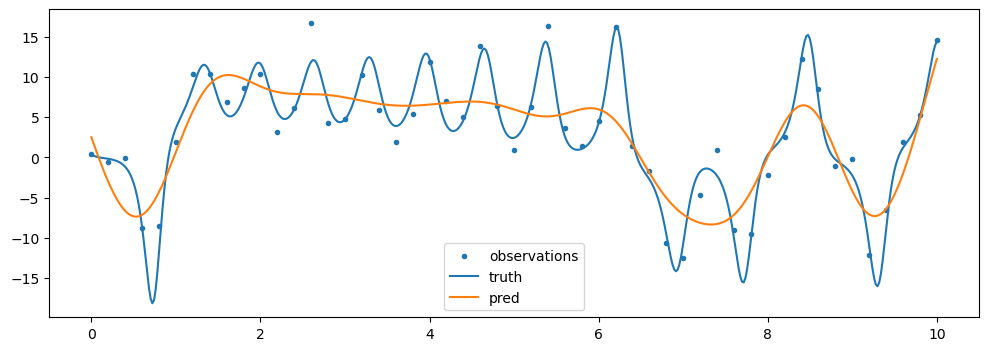

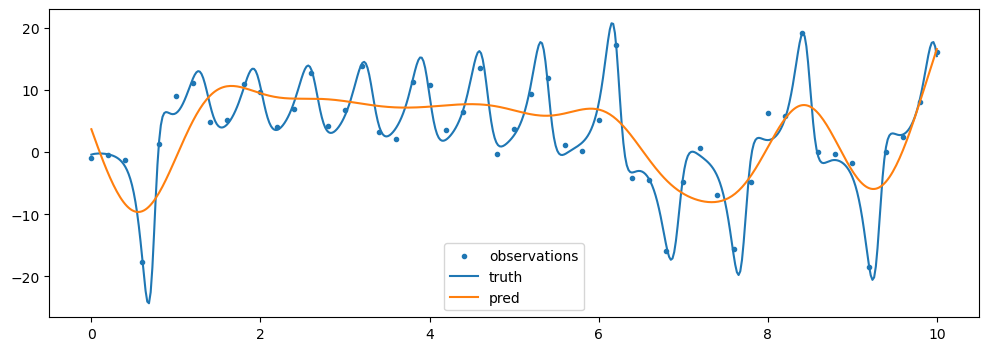

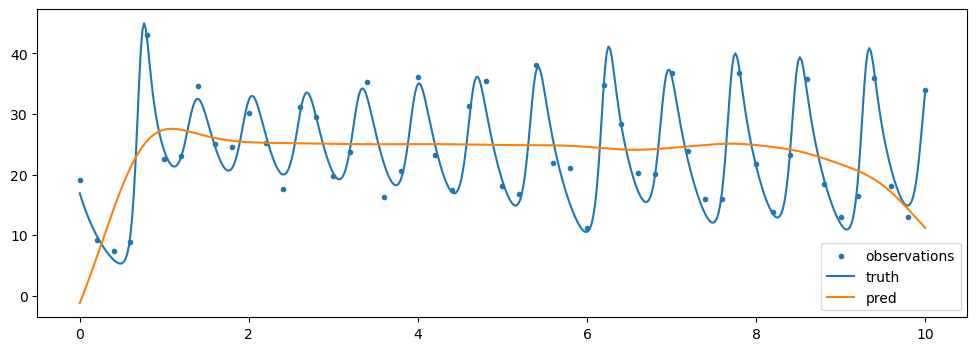

In [7]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()
